In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

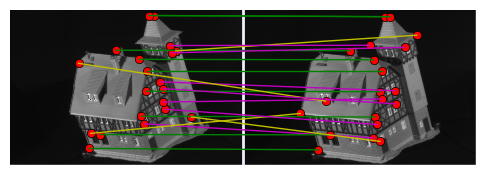

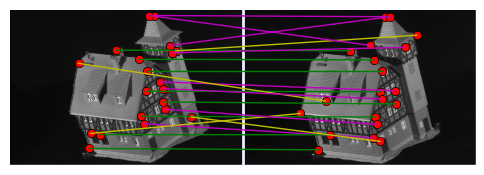

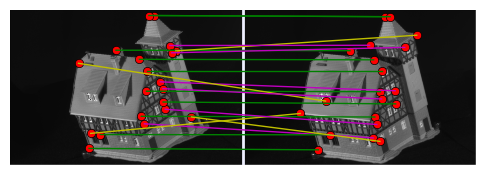

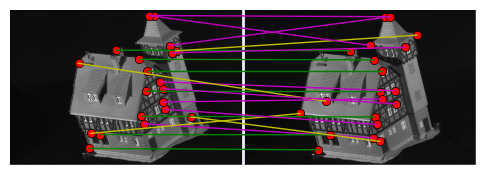

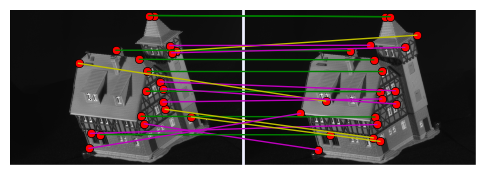

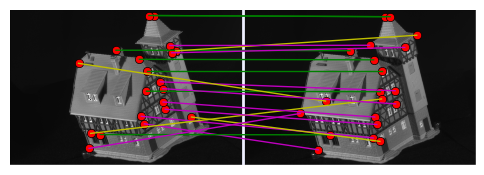

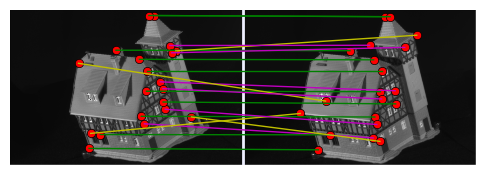

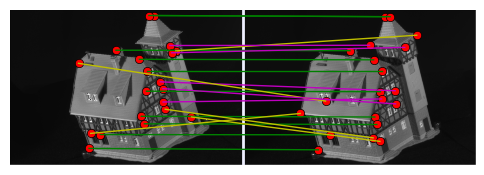

Ours Accuracy 0.692308 Running Time 1.067586 Obj 79.871643
BCA Accuracy 0.615385 Running Time 0.006789 Obj 77.135822
BCA-MP Accuracy 0.538462 Running Time 0.022159 Obj 77.686847
BCA-IPFP Accuracy 0.769231 Running Time 0.011475 Obj 79.320618
HGM Accuracy 0.384615 Running Time 0.003230 Obj 38.058319
RRWHM Accuracy 0.615385 Running Time 0.186349 Obj 74.681942
TM Accuracy 0.461538 Running Time 0.028001 Obj 63.589706
OursPW Accuracy 0.538462 Running Time 2.282978 Obj 63.625130
Ours-BCA Accuracy 0.692308 Running Time 1.078881 Obj 79.871643
FGM Accuracy 0.769231 Running Time 4.385497 Obj 65.042680


In [ ]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import time
import scipy.misc as misc 
import drawMatches as dm
from IPython.display import clear_output

reload(dm)
def ComputeAccurancy(Decode, gTruth, NofNodes):
    NIns = np.sum(gTruth!= -1)
    #print(NIns)
    Ccnt = 0
    for i in range(NofNodes):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NIns

def LoadHouse():
    res = np.zeros([111, 30, 2])
    Imgs = {}
    for i in range(0,111):
        res[i] = np.loadtxt('data/cmum/house/label/house%d' % (i+1))
        Imgs[i] = misc.imread('data/cmum/house/images/house.seq%d.png' %i)
    return res,Imgs

HouseData,HouseImg = LoadHouse()
NofAlgorithms = 10
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA', 'FGM']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])
NofNodes = 30
NofOus = 10
np.random.seed(123456)
for baseline in xrange(10,101,10):
    Accuracy = np.zeros([NofAlgorithms, end - baseline])
    Rtime = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])
    for ImageI in range(start, end - baseline):
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        I1 = HouseImg[ImageI]
        I2 = HouseImg[ImageI + baseline]
        rNofNodes = NofNodes - NofOus
        
        NPT1 = PT1.copy();
        PT1[:,0] = NPT1[:,1]
        PT1[:,1] = NPT1[:,0]
        NPT2 = PT2.copy();
        PT2[:,0] = NPT2[:,1]
        PT2[:,1] = NPT2[:,0]
        
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]


        PF1 = np.zeros([NofNodes - NofOus,1])
        PF2 = np.zeros([NofNodes - NofOus,1])

        gTruth2 = np.random.permutation(NofNodes)
        gTruth2 = np.array(sorted(gTruth2[0:rNofNodes]))

        rGTruth = - np.ones([rNofNodes])
        
        for i in range(rNofNodes):
            N1 = gTruth[i]
            if(N1 not in gTruth2):
                gTruth[i] = -1
            elif N1 in gTruth2:
                gTruth[i] = np.argwhere(gTruth2==N1)
        


        nPT1 = PT1[0:rNofNodes]
        nPT2 = PT2[gTruth2]

        MG1 = FB.MatchingGraph(nPT1[0:rNofNodes], PF1[0:rNofNodes])
        MG2 = FB.MatchingGraph(nPT2[0:rNofNodes], PF2[0:rNofNodes])

        

        G,MFname = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        
        G2 = FB.ConstructMatchingModel(MG1, MG2, 'pas', False)
        Gvis,MFname = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        G.SetVerbose(False)
        
        res1 = FB.BaBSolver(G, 100, 10, 0.005, False)
        res2 = FB.BaBSolver(G2, 600, 5, 0.005, False)

        resFGM = eng.runFGM(MFname,nargout=3)
        resBag = eng.runBcagm(MFname,nargout=3)
        resBagMP = eng.runBcagmQuad1(MFname,1,nargout=3)
        resBagIPFP = eng.runBcagmQuad1(MFname, 2,nargout=3)
        resHGM = eng.runHGM(MFname,nargout=3)
        resRRWHM = eng.runRRWHM(MFname,nargout=3)
        resTM = eng.runTensorMatching(MFname,nargout=3)
        
        start_time = time.time()
        ResForBca = sio.loadmat(MFname)
        X0 = np.zeros(rNofNodes)
        X0Vec = res1.Decode
        for i in xrange(rNofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat(MFname, ResForBca)
        resOursBCA = eng.runBcagm(MFname, nargout=3)
        time_dur = time.time() - start_time
        
        
        
        cDecode = FB.intArray(rNofNodes)
        gTruth = gTruth[0:rNofNodes]
            
        for i in range(rNofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if(res1.Value < Gvis.ComputeObj(cDecode)):
            Accuracy[8][ImageI] = ComputeAccurancy(resOursBCA[1][0], gTruth, rNofNodes)
            Obj[8][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            Accuracy[8][ImageI] = ComputeAccurancy(res1.Decode, gTruth, rNofNodes)
            Obj[8][ImageI] = res1.Value


        Rtime[8][ImageI] = time_dur + res1.Time


        Accuracy[0][ImageI] = ComputeAccurancy(res1.Decode, gTruth, rNofNodes)
        Rtime[0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value

        Accuracy[7][ImageI] = ComputeAccurancy(res2.Decode, gTruth, rNofNodes)
        Rtime[7][ImageI] = res2.Time
        Obj[7][ImageI] = res2.Value

        Accuracy[1][ImageI] = ComputeAccurancy(resBag[1][0], gTruth, rNofNodes)
        Rtime[1][ImageI] = resBag[0]
        cDecode = FB.intArray(rNofNodes)
        for i in range(rNofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[1][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[2][ImageI] = ComputeAccurancy(resBagMP[1][0], gTruth, rNofNodes)
        Rtime[2][ImageI] = resBagMP[0]
        for i in range(rNofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[3][ImageI] = ComputeAccurancy(resBagIPFP[1][0], gTruth, rNofNodes)
        Rtime[3][ImageI] = resBagIPFP[0]
        for i in range(rNofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)


        Accuracy[4][ImageI] = ComputeAccurancy(resHGM[1][0], gTruth, rNofNodes)
        Rtime[4][ImageI] = resHGM[0]
        for i in range(rNofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)


        Accuracy[5][ImageI] = ComputeAccurancy(resRRWHM[1][0], gTruth, rNofNodes)
        Rtime[5][ImageI] = resRRWHM[0]
        for i in range(rNofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[6][ImageI] = ComputeAccurancy(resTM[1][0], gTruth, rNofNodes)
        Rtime[6][ImageI] = resTM[0]
        for i in range(rNofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)
        
        Accuracy[9][ImageI] = ComputeAccurancy(resFGM[1][0], gTruth, rNofNodes)
        Rtime[9][ImageI] = resFGM[0]

        Obj[9][ImageI] = resFGM[2]
        
        Rtime[8][ImageI] = time_dur + res1.Time
        clear_output()
        #print(resOursBCA[1][0])
        #reload(dm)
        idx = ImageI
        Fname = 'House%d_BaseLine%d_Ours.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],res1.Decode, gTruth, rNofNodes, Fname)

        Fname = 'House%d_BaseLine%d_Bca.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],np.array(resBag[1][0]), gTruth, rNofNodes, Fname)

        Fname = 'House%d_BaseLine%d_BcaIPFP.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],np.array(resBagIPFP[1][0]), gTruth, rNofNodes, Fname)

        Fname = 'House%d_BaseLine%d_BcaMP.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],np.array(resBagMP[1][0]), gTruth, rNofNodes, Fname)

        Fname = 'House%d_BaseLine%d_RRWHM.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],np.array(resRRWHM[1][0]), gTruth, rNofNodes, Fname)
        
        Fname = 'House%d_BaseLine%d_PW.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],res2.Decode, gTruth, rNofNodes, Fname)
        
        Fname = 'House%d_BaseLine%d_OursBca.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],np.array(resOursBCA[1][0]), gTruth, rNofNodes, Fname)

        Fname = 'House%d_BaseLine%d_FGM.pdf' % (idx, baseline)
        dm.drawMatchesWithOutlier(I1,I2,nPT1[0:rNofNodes],nPT2[0:rNofNodes],np.array(resFGM[1][0]), gTruth, rNofNodes, Fname)
        
        for ai in xrange(NofAlgorithms):
            print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                            Accuracy[ai][ImageI],
                                                            Rtime[ai][ImageI],
                                                            Obj[ai][ImageI]))
        #print('NofOus %d, Finished Frame: %d' % (NofOus,ImageI) )
    #Todo Ours-BCA
    for ni in range(Obj.shape[1]):
        MaxObj = np.max(Obj[:,ni])
        Obj[:,ni] /= MaxObj
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(Accuracy[ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(Rtime[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        np.mean(Accuracy[ai]),
                                                        np.mean(Rtime[ai]),
                                                        np.mean(Obj[ai])))
 






In [17]:
MeanAcc[:,0] - Ma

array([ 0.83836312,  0.85036868,  0.82591326,  0.81798976,  0.82207144,
        0.78572702,  0.79858056,  0.7645644 ,  0.77491687,  0.76220762])

In [50]:
gTruth[0:rNofNodes]

array([24, 13, 19,  3,  5, 18,  9, -1, 15,  7, -1,  6,  2, -1, -1, 20, 12,
       23, -1,  8,  4,  0, 22, 14, 11])

In [46]:
res1.Decode

array([24, 12, 19,  3,  5, 16,  9,  0, 15,  7, 13,  6,  2, 21, 17, 20, 10,
       18, 23,  8,  4, 22,  1, 14, 11], dtype=int32)

In [81]:
np.sum(gTruth[0:25]!=-1)

20